In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

sns.set()
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#base libraries for analysis
from ssalib2 import SpatialSoccer

In [3]:
sa = SpatialSoccer()
pitchgdf = SpatialSoccer.build_polygon_pitch_statsbomb()
team_name = "Chelsea FCW"
sb_matches = sa.get_match_list_from_source("open-data-master/data/matches/37/4.json",SpatialSoccer.STATS_BOMB_DATA,team_name=team_name)
m = sb_matches[0]
vars(m)

{'match_id': 19743,
 'home_team_id': 969,
 'home_team_name': 'Birmingham City WFC',
 'home_team_score': 0,
 'away_team_id': 971,
 'away_team_name': 'Chelsea FCW',
 'away_team_score': 0,
 'season_id': 0,
 'season_name': '',
 'kick_off': '13:30:00.000',
 'match_date': '2018-10-21',
 'match_date_time': datetime.datetime(2018, 10, 21, 13, 30),
 'events': []}

In [4]:
trajectories = None
   
for m in sb_matches:
    df = sa.load_events_from_match("open-data-master/data/events",SpatialSoccer.STATS_BOMB_DATA,m)
    trajs = m.build_match_trajectories(team_name,only_goals=False)

    try:
        trajectories = trajectories.append(trajs,ignore_index=True,sort=False)
    except:
        try:
            trajectories = trajs.copy()
        except:
            pass
    del trajs
    del df
trajectories.head()

,start_x,start_y,end_x,end_y,is_goal,period,match_id,xg,event_id,event_name,...,timestamp,body_part,tags,original_json,event_time,start_point,end_point,geometry,trajectory_id,temporal_distance
0,94.0,31.0,95.0,31.0,0,1,19743,NaN,f5787bc1-a906-48e6-8afd-f2a910a05030,Carry,...,00:04:35.091,None,None,"{""id"": ""f5787bc1-a906-48e6-8afd-f2a910a05030"",...",2018-10-21 13:34:35.091,POINT (94 31),POINT (95 31),POINT (94.00000 31.00000),19743_11,275.091
1,95.0,31.0,105.0,26.0,0,1,19743,NaN,a726d31f-330f-44ab-8be6-501f5b779f5e,Pass,...,00:04:35.786,None,None,"{""id"": ""a726d31f-330f-44ab-8be6-501f5b779f5e"",...",2018-10-21 13:34:35.786,POINT (95 31),POINT (105 26),POINT (95.00000 31.00000),19743_11,275.786
2,105.0,26.0,NaN,NaN,0,1,19743,NaN,76b34125-a56a-40e5-a974-ae673b07e91e,Ball Receipt*,...,00:04:37.148,None,None,"{""id"": ""76b34125-a56a-40e5-a974-ae673b07e91e"",...",2018-10-21 13:34:37.148,POINT (105 26),None,POINT (105.00000 26.00000),19743_11,277.148
3,105.0,26.0,109.0,34.0,0,1,19743,NaN,ce41e6ae-e09c-4bd0-ac86-66a0f135fd5d,Carry,...,00:04:37.148,None,None,"{""id"": ""ce41e6ae-e09c-4bd0-ac86-66a0f135fd5d"",...",2018-10-21 13:34:37.148,POINT (105 26),POINT (109 34),POINT (105.00000 26.00000),19743_11,277.148
4,109.0,34.0,112.0,35.0,0,1,19743,0.275178,2ce2d620-e651-4d32-b6d8-261199b22bd1,Shot,...,00:04:38.609,None,None,"{""id"": ""2ce2d620-e651-4d32-b6d8-261199b22bd1"",...",2018-10-21 13:34:38.609,POINT (109 34),POINT (112 35),POINT (109.00000 34.00000),19743_11,278.609


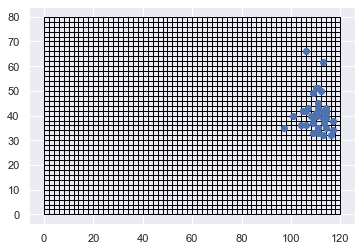

In [6]:
shots = SpatialSoccer.shots_from_trajectories(trajectories)
grid = SpatialSoccer.build_grid(2)
grid['x_coord'] = [p.x for p in grid['centroid'].values]
grid['y_coord'] = [p.y for p in grid['centroid'].values]
ax = grid.plot(facecolor='None',edgecolor="black")
shots[shots['scored']==1].plot(ax=ax);

In [7]:
cell_pnts = grid[['x_coord','y_coord']].values
sht_pnts = shots.loc[shots['scored']==1][['x_coord','y_coord']].values
bw = SpatialSoccer.adhoc_bandwidth(sht_pnts)
print(bw)
grid['densities'] = SpatialSoccer.two_d_kernel(cell_pnts,sht_pnts,bw)

2.300119076754816


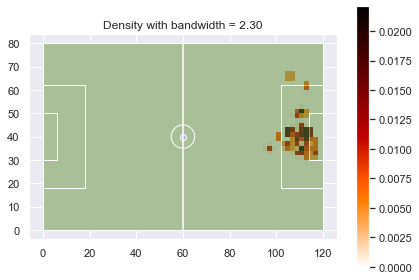

In [8]:
ax = pitchgdf.plot(facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
grid.plot(ax=ax,column='densities',cmap='gist_heat_r',legend=True,alpha=.5,edgecolor='None');
ax.set_title("Density with bandwidth = {:.2f}".format(bw))
plt.tight_layout()
plt.savefig("kerneldensity_chelsea_adhoc_bandwidth.png",dpi=150);

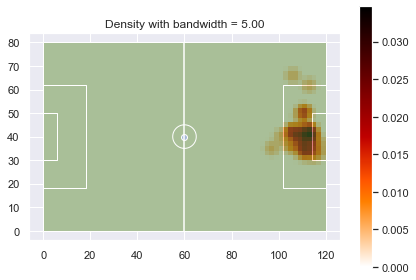

In [9]:
grid['densities_5'] = SpatialSoccer.two_d_kernel(cell_pnts,sht_pnts,5)
ax = pitchgdf.plot(facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
grid.plot(ax=ax,column='densities_5',cmap='gist_heat_r',legend=True,alpha=.5,edgecolor='None');
ax.set_title("Density with bandwidth = {:.2f}".format(5.00))
plt.tight_layout()
plt.savefig("kerneldensity_chelsea_bandwith_5.png",dpi=150);

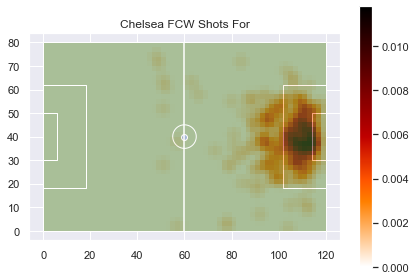

In [10]:
sht_pnts = shots[['x_coord','y_coord']].values
grid['densities_all'] = SpatialSoccer.two_d_kernel(cell_pnts,sht_pnts,5)
ax = pitchgdf.plot(facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
grid.plot(ax=ax,column='densities_all',cmap='gist_heat_r',legend=True,alpha=.5,edgecolor='None');
ax.set_title("{0} Shots For".format(team_name))
plt.tight_layout()
plt.savefig("kerneldensity_chelsea_all_shots.png",dpi=150);

In [11]:
trajectories_against = None
   
for m in sb_matches:
    df = sa.load_events_from_match("open-data-master/data/events",SpatialSoccer.STATS_BOMB_DATA,m)
    trajs = m.build_match_trajectories(team_name,for_team=False,only_goals=False)

    try:
        trajectories_against = trajectories_against.append(trajs,ignore_index=True,sort=False)
    except:
        try:
            trajectories_against = trajs.copy()
        except:
            pass
    del trajs
    del df


In [12]:
shots_against = SpatialSoccer.shots_from_trajectories(trajectories_against)
sht_pnts_a = shots_against.loc[shots['scored']==1][['x_coord','y_coord']].values
grid['densities_against'] = SpatialSoccer.two_d_kernel(cell_pnts,sht_pnts_a,5)

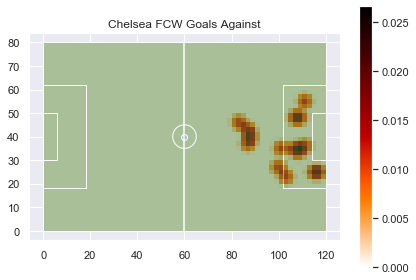

In [13]:
ax = pitchgdf.plot(facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
grid.plot(ax=ax,column='densities_against',cmap='gist_heat_r',legend=True,alpha=.5,edgecolor='None');
ax.set_title("{0} Goals Against".format(team_name))
plt.tight_layout()
plt.savefig("kerneldensity_chelsea_goals_against.png",dpi=150);

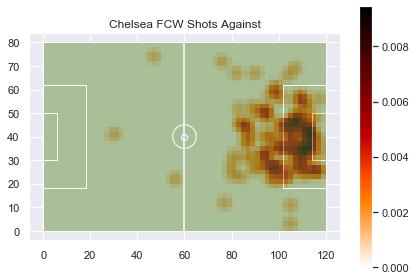

In [14]:
sht_pnts_a = shots_against[['x_coord','y_coord']].values
grid['densities_againstall'] = SpatialSoccer.two_d_kernel(cell_pnts,sht_pnts_a,5)
ax = pitchgdf.plot(facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
grid.plot(ax=ax,column='densities_againstall',cmap='gist_heat_r',legend=True,alpha=.5,edgecolor='None');
ax.set_title("{0} Shots Against".format(team_name))
plt.tight_layout()
plt.savefig("kerneldensity_chelsea_shots_against.png",dpi=150);

In [15]:
import pysal.lib as ps
from pysal.explore.pointpats import PointPattern
from pysal.explore.pointpats import PoissonPointProcess, K, Kenv, L, Lenv
from pysal.explore.pointpats.window import to_ccf
from pysal.explore.pointpats import Window
pitch_window = Window(to_ccf([(0,0),(120,0),(120,80),(0,80)]))
pitch_window.bbox
goals_for = PointPattern(shots.loc[shots['scored']==1][['x_coord','y_coord']].values)
goals_against = PointPattern(shots_against.loc[shots_against['scored']==1][['x_coord','y_coord']].values)

C:\Users\davidlamb\.conda\envs\Spatial\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [16]:
goals_for.mean_nnd

1.920529168820754

In [17]:
goals_against.mean_nnd

5.016248935829172

In [18]:
team_name = "Everton LFC"
sb_matches = sa.get_match_list_from_source("open-data-master/data/matches/37/4.json",SpatialSoccer.STATS_BOMB_DATA,team_name=team_name)
trajectories = None
   
for m in sb_matches:
    df = sa.load_events_from_match("open-data-master/data/events",SpatialSoccer.STATS_BOMB_DATA,m)
    trajs = m.build_match_trajectories(team_name,only_goals=False)

    try:
        trajectories = trajectories.append(trajs,ignore_index=True,sort=False)
    except:
        try:
            trajectories = trajs.copy()
        except:
            pass
    del trajs
    del df
shots = SpatialSoccer.shots_from_trajectories(trajectories)
trajectories_against = None
   
for m in sb_matches:
    df = sa.load_events_from_match("open-data-master/data/events",SpatialSoccer.STATS_BOMB_DATA,m)
    trajs = m.build_match_trajectories(team_name,for_team=False,only_goals=False)

    try:
        trajectories_against = trajectories_against.append(trajs,ignore_index=True,sort=False)
    except:
        try:
            trajectories_against = trajs.copy()
        except:
            pass
    del trajs
    del df
shots_against = SpatialSoccer.shots_from_trajectories(trajectories_against)




In [19]:
grid = SpatialSoccer.build_grid(2)
grid['x_coord'] = [p.x for p in grid['centroid'].values]
grid['y_coord'] = [p.y for p in grid['centroid'].values]
cell_pnts = grid[['x_coord','y_coord']].values
sht_pnts = shots.loc[shots['scored']==1][['x_coord','y_coord']].values

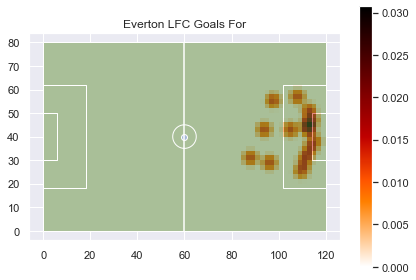

In [20]:
grid['densities_5'] = SpatialSoccer.two_d_kernel(cell_pnts,sht_pnts,5)
ax = pitchgdf.plot(facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
grid.plot(ax=ax,column='densities_5',cmap='gist_heat_r',legend=True,alpha=.5,edgecolor='None');
ax.set_title("{0} Goals For".format(team_name))
plt.tight_layout()
plt.savefig("kerneldensity_everton_goals_for.png",dpi=150);

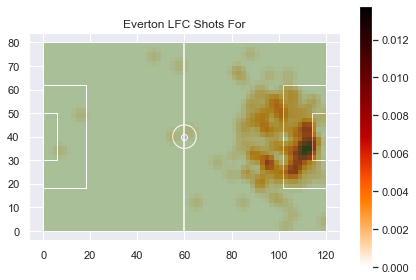

In [21]:
sht_pnts = shots[['x_coord','y_coord']].values
grid['densities_5all'] = SpatialSoccer.two_d_kernel(cell_pnts,sht_pnts,5)
ax = pitchgdf.plot(facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
grid.plot(ax=ax,column='densities_5all',cmap='gist_heat_r',legend=True,alpha=.5,edgecolor='None');
ax.set_title("{0} Shots For".format(team_name))
plt.tight_layout()
plt.savefig("kerneldensity_everton_shots_for.png",dpi=150);

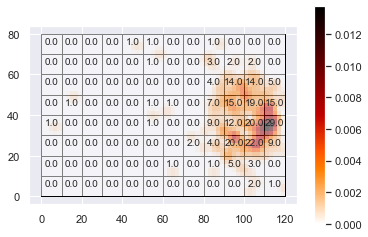

In [24]:
grid_big = SpatialSoccer.build_grid(10)
#grid_big.plot();
grid_big['x_coord'] = [p.x for p in grid_big['centroid'].values]
grid_big['y_coord'] = [p.y for p in grid_big['centroid'].values]
#grid_big.head()
s_join = gpd.sjoin(grid_big,shots)
gridpasscount = grid_big.merge(s_join.groupby("cell")['centroid'].count().reset_index().rename(columns={'centroid':'count'}), how='left',on='cell')
gridpasscount['count'].fillna(0,inplace=True)
ax = gridpasscount.plot(facecolor='None',edgecolor="black")
gridpasscount.apply(lambda x: ax.annotate(s=x['count'], xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
grid.plot(ax=ax,column='densities_5all',cmap='gist_heat_r',legend=True,alpha=.5,edgecolor='None');
plt.savefig("everton_count_over_density.png",dpi=150)

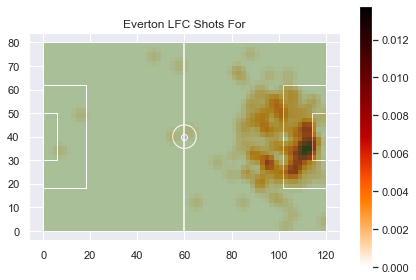

In [25]:
ax = pitchgdf.plot(facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
grid.plot(ax=ax,column='densities_5all',cmap='gist_heat_r',legend=True,alpha=.5,edgecolor='None');
ax.set_title("{0} Shots For".format(team_name))
plt.tight_layout()
plt.savefig("kerneldensity_everton_shots_for.png",dpi=150);

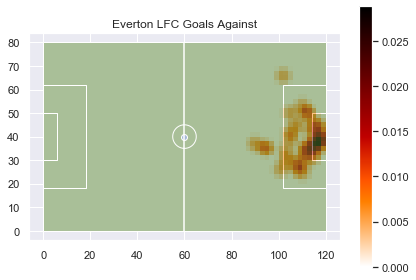

In [26]:

sht_pnts_a = shots_against.loc[shots_against['scored']==1][['x_coord','y_coord']].values
grid['densities_against'] = SpatialSoccer.two_d_kernel(cell_pnts,sht_pnts_a,5)
ax = pitchgdf.plot(facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
grid.plot(ax=ax,column='densities_against',cmap='gist_heat_r',legend=True,alpha=.5,edgecolor='None');
ax.set_title("{0} Goals Against".format(team_name))
plt.tight_layout()
plt.savefig("kerneldensity_everton_goals_against.png",dpi=150);

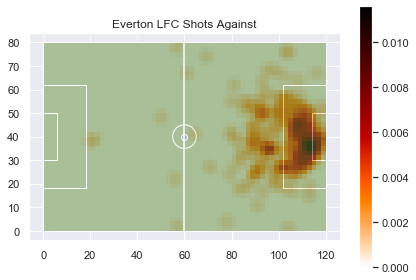

In [27]:
sht_pnts_a = shots_against[['x_coord','y_coord']].values
grid['densities_againstall'] = SpatialSoccer.two_d_kernel(cell_pnts,sht_pnts_a,5)
ax = pitchgdf.plot(facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
grid.plot(ax=ax,column='densities_againstall',cmap='gist_heat_r',legend=True,alpha=.5,edgecolor='None');
ax.set_title("{0} Shots Against".format(team_name))
plt.tight_layout()
plt.savefig("kerneldensity_everton_shots_against.png",dpi=150);

In [28]:
goals_for = PointPattern(shots.loc[shots['scored']==1][['x_coord','y_coord']].values)
goals_against = PointPattern(shots_against.loc[shots_against['scored']==1][['x_coord','y_coord']].values)
goals_for.mean_nnd

5.892414119654524

In [29]:
goals_against.mean_nnd

2.7962235166165135

In [30]:
teams = ["Arsenal WFC", "Manchester City WFC", "Chelsea FCW","Birmingham City WFC","Reading WFC", "Bristol City WFC", "West Ham United LFC", 
         "Liverpool WFC","Brighton & Hove Albion WFC","Everton LFC"]
results = {"teams":[],"gfknn":[],"gaknn":[],"sfknn":[],"saknn":[],"shotsfor":[],"shotsagainst":[]}


for team_name in teams:
    sb_matches = sa.get_match_list_from_source("open-data-master/data/matches/37/4.json",SpatialSoccer.STATS_BOMB_DATA,team_name=team_name)
    trajectories = None

    for m in sb_matches:
        df = sa.load_events_from_match("open-data-master/data/events",SpatialSoccer.STATS_BOMB_DATA,m)
        trajs = m.build_match_trajectories(team_name,only_goals=False)

        try:
            trajectories = trajectories.append(trajs,ignore_index=True,sort=False)
        except:
            try:
                trajectories = trajs.copy()
            except:
                pass
        del trajs
        del df
    shots = SpatialSoccer.shots_from_trajectories(trajectories)
    trajectories_against = None

    for m in sb_matches:
        df = sa.load_events_from_match("open-data-master/data/events",SpatialSoccer.STATS_BOMB_DATA,m)
        trajs = m.build_match_trajectories(team_name,for_team=False,only_goals=False)

        try:
            trajectories_against = trajectories_against.append(trajs,ignore_index=True,sort=False)
        except:
            try:
                trajectories_against = trajs.copy()
            except:
                pass
        del trajs
        del df
    shots_against = SpatialSoccer.shots_from_trajectories(trajectories_against)
    goals_for = PointPattern(shots.loc[shots['scored']==1][['x_coord','y_coord']].values)
    goals_against = PointPattern(shots_against.loc[shots_against['scored']==1][['x_coord','y_coord']].values)
    s_for = PointPattern(shots[['x_coord','y_coord']].values)
    s_against = PointPattern(shots_against[['x_coord','y_coord']].values)
    results['teams'].append(team_name)
    #results['gfknn'].append(np.median(goals_for.knn()[1]))
    #results['gaknn'].append(np.median(goals_against.knn()[1]))
    #results['saknn'].append(np.median(s_against.knn()[1]))
    #results['sfknn'].append(np.median(s_for.knn()[1]))
    results['shotsfor'].append(len(shots))
    results['shotsagainst'].append(len(shots_against))
    results['gfknn'].append(goals_for.mean_nnd)
    results['gaknn'].append(goals_against.mean_nnd)
    results['saknn'].append(s_against.mean_nnd)
    results['sfknn'].append(s_for.mean_nnd)
    
    del s_for
    del s_against
    del goals_for
    del goals_against
    del shots
    del shots_against

In [31]:
results = pd.DataFrame(results)
results['gfga'] = results['gfknn']/results['gaknn']
results.sort_values("gfga")

,teams,gfknn,gaknn,sfknn,saknn,shotsfor,shotsagainst,gfga
0,Arsenal WFC,1.792191,4.966072,1.443622,2.600108,334,139,0.360887
2,Chelsea FCW,1.920529,5.016249,1.333160,2.635101,356,130,0.382862
7,Liverpool WFC,1.804016,3.960255,1.951077,2.016159,160,260,0.455530
1,Manchester City WFC,2.219548,4.309176,1.434242,1.971115,349,213,0.515075
3,Birmingham City WFC,3.462172,3.814642,2.196840,2.098516,233,176,0.907601
6,West Ham United LFC,2.834094,2.767395,2.489799,2.086489,197,240,1.024102
4,Reading WFC,3.316382,2.694547,1.933309,1.827679,276,236,1.230776
8,Brighton & Hove Albion WFC,3.307212,2.399983,1.906175,1.715947,188,242,1.378015
9,Everton LFC,5.892414,2.796224,2.119700,2.001144,207,237,2.107276
5,Bristol City WFC,6.522046,2.603783,2.228401,1.538561,149,279,2.504835
